In [9]:
# Import all necessary libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib
from pylab import *
import numpy as np
import random

"""
Com a função mágica abaixo, a saída dos comandos de plot do biblioteca matplotlib é exibida inline, 
ou seja, diretamente abaixo da célula de código que a produziu. Os plots resultantes também serão armazenadas no notebook.
Para mais informações: https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained
"""

%matplotlib inline

In [10]:
# Always reset the pseudo-random numbers generator to a known value so that your results are always the same.
np.random.seed(1234)

In [11]:
# Number of pairs feature/label.
N = 10000

In [12]:
# Input values (features)
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# True model.
y = x1 + x2

# Observable function.
y_noisy = y + np.random.randn(N, 1)

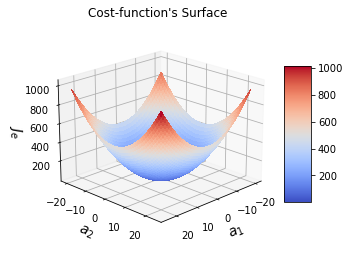

In [4]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-20.0, 24.0, M)
a2 = np.linspace(-20.0, 24.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    
    for iter2 in range(0, M):
        
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
    
        J[iter1][iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat));

# Plot cost-function surface.
fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14);
plt.title('Cost-function\'s Surface')
ax.view_init(20, 45)
#Show the plot.
plt.savefig("superficie_de_erro_ajuste_passo_de_aprendizagem.png", dpi=600)
plt.show()

In [5]:
# Closed-form solution.
X = np.block([x1,x2])

a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

yhat = X.dot(a_opt)

Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

In [6]:
# Gradient-descent solution.
maxEpochs = 10000

alpha = 0.5

#alpha = 0.01 # Too small learning rate.
#alpha = 0.9 # Too large learning rate.
#alpha = 0.5 # Empirically found optimum learning rate.

# Create empty structures.
a_hist = np.zeros((2, maxEpochs))
Jgd = np.zeros(maxEpochs)
a_aux = np.zeros((2,1))

# Intialize the weights.
a = np.array([-20.0, -20.0]).reshape(2, 1)

a_hist[:, 0] = a.reshape(2,)

# Calculate the error for the initial weights.
yhat = X.dot(a)
Jgd[0] = (1.0/N)*np.sum(np.power(y_noisy - yhat, 2))

error = 1;
iteration = 0;
while(error > 0.001 and iteration < maxEpochs-1):
    
    # Hypothesis function.
    h = X.dot(a)
    
    # Calculate gradient vector.
    gradients = -(2.0/N)*X.T.dot(y_noisy - h)
    
    # Weight update rule.
    a = a - alpha*gradients
    
    # Store weight variation.
    a_hist[:, iteration+1] = a.reshape(2,)

    # Calculate and store actual error.
    yhat = X.dot(a)
    Jgd[iteration+1] = (1.0/N)*sum(np.power(y_noisy - yhat, 2))    
    
    # Error difference between actual and previous iteration.
    error = np.abs(Jgd[iteration]-Jgd[iteration+1])   
    
    iteration = iteration + 1

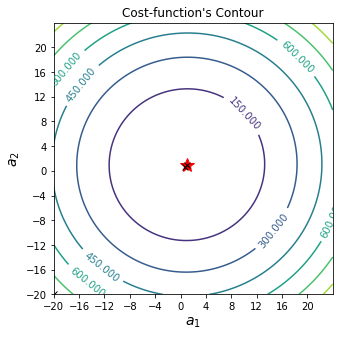

In [7]:
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*', markersize=14)
plt.plot(a_hist[0, 0:iteration], a_hist[1, 0:iteration], 'kx')
plt.xticks(np.arange(-20, 24, step=4.0))
plt.yticks(np.arange(-20, 24, step=4.0))
plt.savefig("superficie_de_contorno_ajuste_passo_de_aprendizagem.png", dpi=600)
plt.show()

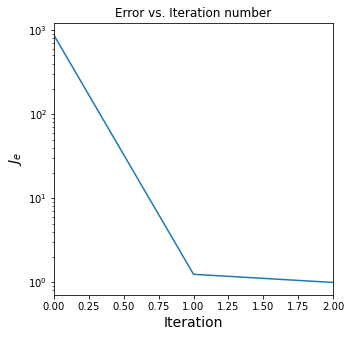

In [8]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(0, iteration), Jgd[0:iteration])
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.xlim(0, iteration-1)
plt.savefig("erro_vs_epoca_ajuste_passo_de_aprendizagem.png", dpi=600)
plt.show()